Данные для J>0: 71 точек
Данные для J>0.5: 71 точек


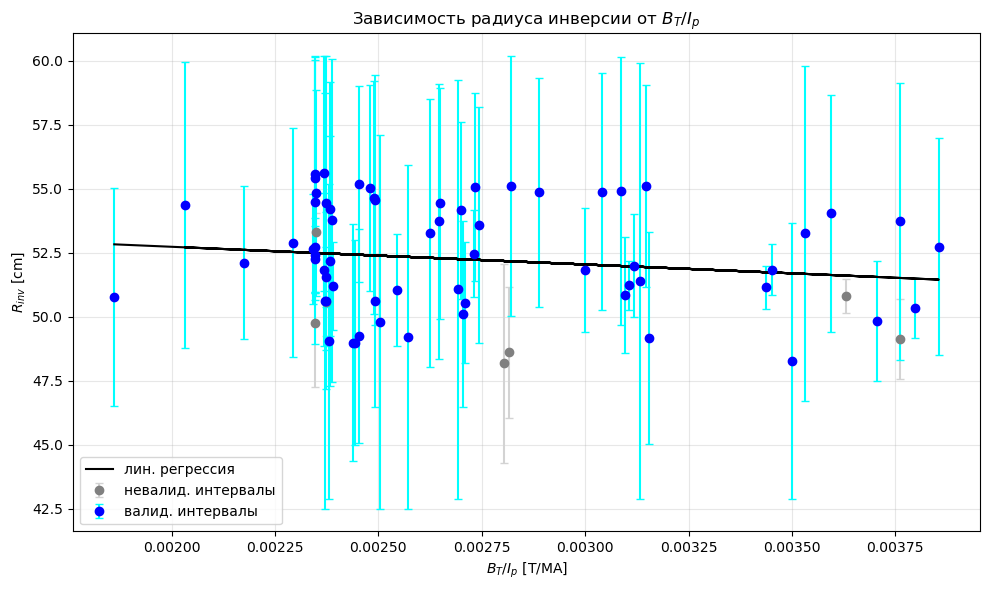


--- Регрессия для J > 0 ---
Уравнение: R_inv = -691.478 * (Bt/Ip) + 54.122
Коэффициент детерминации R²: 0.024
Число точек, пересекающих прямую: 64 из 71


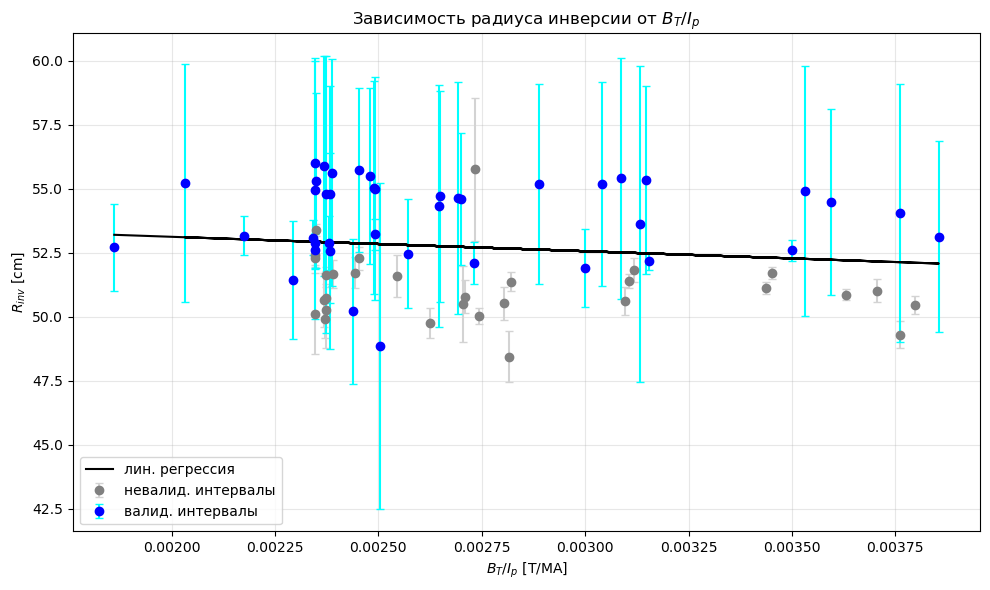


--- Регрессия для J > 0.5 ---
Уравнение: R_inv = -563.355 * (Bt/Ip) + 54.256
Коэффициент детерминации R²: 0.018
Число точек, пересекающих прямую: 41 из 71


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.stats import linregress
import re

df_rad = pd.read_csv("inversion radius1.csv").dropna()
df_norm = pd.read_csv("normalised_export.csv", sep=',', encoding='cp1251', low_memory=False).dropna()

df_norm['shotn'] = pd.to_numeric(df_norm['shotn'], errors='coerce')
df_norm['time'] = pd.to_numeric(df_norm['time'], errors='coerce')

df_norm = df_norm.dropna(subset=['shotn', 'time']).reset_index(drop=True)

df_norm = df_norm.dropna(subset=['shotn', 'time', 'R']).reset_index(drop=True)


def jaccard_coefficient_interval(interval1, interval2):
    a1, b1 = min(interval1), max(interval1)
    a2, b2 = min(interval2), max(interval2)
    intersection_start = max(a1, a2)
    intersection_end = min(b1, b2)
    if intersection_start >= intersection_end:
        return 0.0
    union_start = min(a1, a2)
    union_end = max(b1, b2)
    union_length = union_end - union_start
    if union_length == 0:
        return 1.0
    return (intersection_end - intersection_start) / union_length

def process_shot(shot, t1, t2, df_norm):
    dff = df_norm[df_norm['shotn'] == shot].copy()
    if dff.empty:
        return None, None, None, None, None, None, None

    mask1 = np.abs(dff['time'] - t1) <= 0.1
    mask2 = np.abs(dff['time'] - t2) <= 0.1

    if not mask1.any() or not mask2.any():
        return None, None, None, None, None, None, None

    df1 = dff[mask1]
    df2 = dff[mask2]

    def extract_data(df):
        Te_mean = pd.to_numeric(df["<Te>"], errors='coerce').values
        Te_ratio = pd.to_numeric(df["T_e/<Te>"], errors='coerce').values
        R = pd.to_numeric(df["R"], errors='coerce').values

    
        Te = Te_mean * Te_ratio

    
        valid_mask = (R >= 42.4)
        R_clean = R[valid_mask]
        Te_clean = Te[valid_mask]

        return R_clean, Te_clean

    R1, Te1 = extract_data(df1)
    R2, Te2 = extract_data(df2)

    if len(R1) < 2 or len(R2) < 2:
        return None, None, None, None, None, None, None

    
    idx1 = np.argsort(R1); R1_s, Te1_s = R1[idx1], Te1[idx1]
    idx2 = np.argsort(R2); R2_s, Te2_s = R2[idx2], Te2[idx2]

    
    spline1 = interp1d(R1_s, Te1_s, kind='linear', fill_value='extrapolate', bounds_error=False)
    spline2 = interp1d(R2_s, Te2_s, kind='linear', fill_value='extrapolate', bounds_error=False)

    R_min = min(R1_s.min(), R2_s.min())
    R_max = max(R1_s.max(), R2_s.max())
    R_grid = np.linspace(R_min, R_max, 500)

    Te1_interp = spline1(R_grid)
    Te2_interp = spline2(R_grid)

    
    J = []
    for i in range(len(R_grid)):
        int1 = (0.95 * Te1_interp[i], 1.05 * Te1_interp[i])
        int2 = (0.95 * Te2_interp[i], 1.05 * Te2_interp[i])
        j = jaccard_coefficient_interval(int1, int2)
        J.append(max(j, 0.0))
    J = np.array(J)

    # Внешний интервал (J > 0)
    mask_ext = J > 0 
    if np.any(mask_ext):
        R_ext = R_grid[mask_ext]
        R_inv_ext = np.mean([R_ext.min(), R_ext.max()])
        R_ext_low, R_ext_high = R_ext.min(), R_ext.max()
    else:
        R_inv_ext = R_ext_low = R_ext_high = np.nan

    # Внутренний интервал (J > 0.5)
    mask_int = J > 0.5
    if np.any(mask_int):
        R_int = R_grid[mask_int]
        R_inv_int = np.mean([R_int.min(), R_int.max()])
        R_int_low, R_int_high = R_int.min(), R_int.max()
    else:
        R_inv_int = R_int_low = R_int_high = np.nan

    # Bt/Ip
    Bt = pd.to_numeric(df1["B_T"].iloc[0], errors='coerce')
    Ip = pd.to_numeric(df1["I_p"].iloc[0], errors='coerce')
    if np.isnan(Bt) or np.isnan(Ip) or Ip == 0:
        Bt_Ip = np.nan
    else:
        Bt_Ip = Bt / (Ip )

    return Bt_Ip, R_inv_ext, R_ext_low, R_ext_high, R_inv_int, R_int_low, R_int_high


results_ext = []
results_int = []

for _, row in df_rad.iterrows():
    shot = row['shotn']
    if pd.isna(shot):
        continue
    t1 = row['ts_time 1']
    t2 = row['ts_time 2']
    
    
    Bt_Ip, R_inv_ext, R_ext_low, R_ext_high, R_inv_int, R_int_low, R_int_high = process_shot(shot, t1, t2, df_norm)
    
    if Bt_Ip is not None and not np.isnan(Bt_Ip):
        if not np.isnan(R_inv_ext):
            results_ext.append({
                'shot': int(shot),
                'Bt_Ip': Bt_Ip,
                'R_inv': R_inv_ext,
                'R_low': R_ext_low,
                'R_high': R_ext_high
            })
        if not np.isnan(R_inv_int):
            results_int.append({
                'shot': int(shot),
                'Bt_Ip': Bt_Ip,
                'R_inv': R_inv_int,
                'R_low': R_int_low,
                'R_high': R_int_high
            })

df_res_ext = pd.DataFrame(results_ext)
df_res_int = pd.DataFrame(results_int)

print(f"Данные для J>0: {len(df_res_ext)} точек")
print(f"Данные для J>0.5: {len(df_res_int)} точек")

# === Визуализация ===
def plot_regression(df_res, title_suffix=""):
    if df_res.empty:
        print(f"Нет данных для {title_suffix}")
        return None 
    
    x = df_res['Bt_Ip'].values
    y = df_res['R_inv'].values
    y_low = df_res['R_low'].values
    y_high = df_res['R_high'].values

    
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    y_fit = slope * x + intercept

    
    intersects = (y_fit >= y_low) & (y_fit <= y_high)

    
    intersecting_indices = df_res.index[intersects].tolist()

    
    plt.figure(figsize=(10, 6))

    mask_no = ~intersects
    if np.any(mask_no):
        plt.errorbar(x[mask_no], y[mask_no],
                     yerr=[y[mask_no] - y_low[mask_no], y_high[mask_no] - y[mask_no]],
                     fmt='o', color='gray', ecolor='lightgray', capsize=3, label="невалид. интервалы")

    if np.any(intersects):
        plt.errorbar(x[intersects], y[intersects],
                     yerr=[y[intersects] - y_low[intersects], y_high[intersects] - y[intersects]],
                     fmt='o', color='blue', ecolor='cyan', capsize=3, label="валид. интервалы")

    plt.plot(x, y_fit, color='black',
             label=f'лин. регрессия')

    plt.xlabel('$B_T / I_p$ [T/MA]')
    plt.ylabel('$R_{inv}$ [cm]')
    plt.title(f'Зависимость радиуса инверсии от $B_T / I_p$ ')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    
    print(f"\n--- Регрессия для {title_suffix} ---")
    print(f"Уравнение: R_inv = {slope:.3f} * (Bt/Ip) + {intercept:.3f}")
    print(f"Коэффициент детерминации R²: {r_value**2:.3f}")
    print(f"Число точек, пересекающих прямую: {np.sum(intersects)} из {len(x)}")

    
    return {
        'indices': intersecting_indices,               # индексы в df_res
        'shotns': df_res.loc[intersecting_indices, 'shot'].tolist(),  # соответствующие shotn
        'slope': slope,
        'intercept': intercept,
        'r_squared': r_value**2
    }

IND_ext = plot_regression(df_res_ext, "J > 0")
IND_int = plot_regression(df_res_int, "J > 0.5")

In [2]:
def build_linear_corridor(df_res_int, indices, use_tolerance=False, tolerance_frac=0.02):

   
    x_raw = df_res_int['Bt_Ip'].values[indices]
    y_low_raw = df_res_int['R_low'].values[indices]
    y_high_raw = df_res_int['R_high'].values[indices]

    assert len(x_raw) == len(y_low_raw) == len(y_high_raw), "Несовпадение длин массивов!"

    sort_idx = np.argsort(x_raw)
    x_sorted = x_raw[sort_idx]
    y_low_sorted = y_low_raw[sort_idx]
    y_high_sorted = y_high_raw[sort_idx]
    n = len(x_sorted)

    if n < 2:
        return None  

    
    if use_tolerance:
        y_span = y_high_sorted.max() - y_low_sorted.min()
        eps = tolerance_frac * y_span
    else:
        eps = 0.0

    
    lines = []

    for i in range(n):
        for j in range(i + 1, n):
            xi, yli, yhi = x_sorted[i], y_low_sorted[i], y_high_sorted[i]
            xj, ylj, yhj = x_sorted[j], y_low_sorted[j], y_high_sorted[j]

            candidates = [
                ((xi, yli), (xj, ylj)),
                ((xi, yli), (xj, yhj)),
                ((xi, yhi), (xj, ylj)),
                ((xi, yhi), (xj, yhj)),
            ]

            for (x1, y1), (x2, y2) in candidates:
                if np.isclose(x1, x2):
                    continue

                a = (y2 - y1) / (x2 - x1)
                b = y1 - a * x1

                # Проверка на всех остальных точках
                valid = True
                for k in range(n):
                    if k == i or k == j:
                        continue
                    xk = x_sorted[k]
                    y_pred = a * xk + b
                    y_low_k = y_low_sorted[k] - eps
                    y_high_k = y_high_sorted[k] + eps

                    if not (y_low_k <= y_pred <= y_high_k):
                        valid = False
                        break

                if valid:
                    lines.append((a, b))

    
    if not lines:
        return None

    x_grid = np.linspace(x_sorted.min(), x_sorted.max(), 50)
    y_min = np.full_like(x_grid, np.inf, dtype=float)
    y_max = np.full_like(x_grid, -np.inf, dtype=float)

    for a, b in lines:
        y_line = a * x_grid + b
        y_min = np.minimum(y_min, y_line)
        y_max = np.maximum(y_max, y_line)

    return {
        'x': x_grid,
        'y_lower': y_min,
        'y_upper': y_max,
        'lines': lines
    }

In [3]:
def extend_corridor(corridor, x_new):

    x_new = np.asarray(x_new, dtype=float)
    y_min = np.full_like(x_new, np.inf, dtype=float)
    y_max = np.full_like(x_new, -np.inf, dtype=float)

    for a, b in corridor['lines']:
        y_line = a * x_new + b
        y_min = np.minimum(y_min, y_line)
        y_max = np.maximum(y_max, y_line)

    return {
        'x': x_new,
        'y_lower': y_min,
        'y_upper': y_max
    }

In [ ]:
def plot_regression_pred(df_res, title_suffix=""):
    if df_res.empty:
        print(f"Нет данных для {title_suffix}")
        return None  # ничего не возвращаем
    
    x = df_res['Bt_Ip'].values
    y = df_res['R_inv'].values
    y_low = df_res['R_low'].values
    y_high = df_res['R_high'].values

   

    # Регрессия
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    y_fit = slope * x + intercept

    
    intersects = (y_fit >= y_low) & (y_fit <= y_high)

    
    intersecting_indices = df_res.index[intersects].tolist()


    corridor = build_linear_corridor(df_res_int, IND_int['indices'], use_tolerance=False, tolerance_frac=0.02)

    
    x_orig_min = x.min()
    x_orig_max = x.max()
    
    
    margin = 2.0 * (x_orig_max - x_orig_min)
    x_extended = np.linspace(
        x_orig_min,
        x_orig_max + margin,
        100
    )
    
    
    extended = extend_corridor(corridor, x_extended)

    X_pred = x_extended

    Y_pred = []

    for i in range(len(X_pred)):
        Y_pred.append(X_pred[i]*(-563.355) + 54.256)

    
    
    plt.figure(figsize=(10, 6))

    plt.fill_between(extended['x'], extended['y_lower'], extended['y_upper'], color='green', alpha=0.3, label='Коридор')
    
    mask_no = ~intersects
    #if np.any(mask_no):
    #    plt.errorbar(x[mask_no], y[mask_no],
    #                 yerr=[y[mask_no] - y_low[mask_no], y_high[mask_no] - y[mask_no]],
    #                 fmt='o', color='gray', ecolor='lightgray', capsize=3, label="невалид. интервалы")

    if np.any(intersects):
        plt.errorbar(x[intersects], y[intersects],
                     yerr=[y[intersects] - y_low[intersects], y_high[intersects] - y[intersects]],
                     fmt='o', color='blue', ecolor='lightblue', capsize=3, label="валид. интервалы")

    
    plt.plot(X_pred, Y_pred, color = "green")

    plt.plot(x, y_fit, color='green',
             label=f'лин. регрессия')


    y_l = np.array(extended['y_lower'])
    y_u = np.array(extended['y_upper'])

    print(y_l)
    y_medium_last = (y_l[-1]+y_u[-1]) /2

    y_medium_m = (y_l[-30]+y_u[-30]) /2

    x_points = [X_pred[-30], X_pred[-1]]
    y_points = [y_medium_m, y_medium_last]
    yerr_asym = [
    [y_medium_m - y_l[-30], y_medium_last - y_l[-1]],      # нижние ошибки
    [y_u[-30] - y_medium_m, y_u[-1] - y_medium_last]       # верхние ошибки
    ]

    plt.errorbar(
    x_points,
    y_points,
    yerr=yerr_asym,
    fmt='o', color='red', ecolor='red', capsize=3,
    label="предикт. интервалы"
    )
    
    
    
    plt.xlabel('$B_T / I_p$ [T/MA]')
    plt.ylabel('$R_{inv}$ [cm]')
    plt.title(f'Зависимость радиуса инверсии от $B_T / I_p$ ')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    
    print(f"\n--- Регрессия для {title_suffix} ---")
    #print(f"Уравнение: R_inv = {slope:.3f} * (Bt/Ip) + {intercept:.3f}")
    print(f"Коэффициент детерминации R²: {r_value**2:.3f}")
    print(f"Число точек, пересекающих прямую: {np.sum(intersects)} из {len(x)}")

   



plot_regression_pred(df_res_inv, "J > 0.5")